In [1]:
import numpy as np
import sys
sys.path.insert(0, '../../../') #This line adds '../../../' to the path so we can import the net_framework python file
from RNN_model_GRAD import *
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
try:
    import ujson as json
except ImportError:
    import json
import scipy.linalg as slin
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib as mpl

## Loading Trained Weights

Having trained the network weights on the remote computer, and loading the weights

In [2]:
with open('256_nodes/weight_history_0.json') as f:
    weight_history = json.load(f)

In [3]:
weight_history.keys()

dict_keys(['bias', 'input weights', 'trained weights', 'connectivity matrix', 'output weights', 'noise weights'])

Defining weights of the network. Final trained weights are in final_weights

In [4]:
noise_weights = np.array(weight_history['noise weights'])
bias_weights = np.array(weight_history['bias'])
input_weights = np.array(weight_history['input weights'])
output_weight_matrix = np.array(weight_history['output weights'])
connectivity_matrix = np.array(weight_history['connectivity matrix'])
final_weights = np.array(weight_history['trained weights'][-1])
initial_weights=np.array(weight_history['trained weights'][0])

## Defining Network

In [5]:
num_nodes = 256
time_constant = 100 #ms
timestep = 10 #ms
noise_strength = 0.01

weight_matrix = tf.Variable(final_weights)
connectivity_matrix = tf.constant(connectivity_matrix)

input_weight_matrix = tf.constant(np.vstack((bias_weights, noise_weights, input_weights)))

def rule_input(time):
    #No input for now
    return 0
    
def bias(time):
    return 1
def noise(time):
    return np.sqrt(2 * time_constant/timestep) * noise_strength * np.random.normal(0, 1)


input_funcs = [bias, noise, rule_input]

init_activations = tf.constant(np.zeros((num_nodes, 1)))
output_weight_matrix = tf.constant(output_weight_matrix)
        
network = RNN(weight_matrix, connectivity_matrix, init_activations, output_weight_matrix, time_constant = time_constant,
             timestep = timestep,activation_func = keras.activations.relu, output_nonlinearity = lambda x : x)

## Simulating Network Output Without Input

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1308.97it/s]


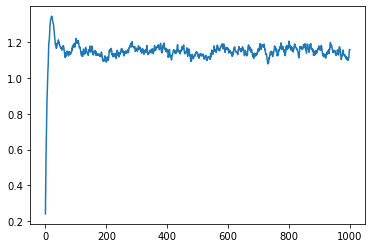

In [6]:
time = 10000 #ms
inputs = network.convert(time, input_funcs)
outputs, activations = network.simulate(time, inputs, input_weight_matrix)

outputs = tf.transpose(outputs).numpy()[0]
fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.show()

## Testing Network

Now, simulating network activity to ensure that it works.

In [7]:
network.reset_activations()
def rule_input(time):
    #running for 5 seconds = 5000ms
    if time < 5000:
        return .5 + np.random.normal(0, .05)
    else:
        return .8 + np.random.normal(0, .05)
def target_func(time):
    #running for 5 seconds = 5000ms
    #Reverse of rule_input
    if time < 5000:
        return .8
    else:
        return .5

input_funcs[2] = rule_input
inputs = network.convert(time, input_funcs)

outputs, activations = network.simulate(time, inputs, input_weight_matrix)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1537.84it/s]


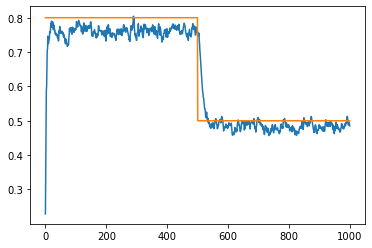

In [8]:

outputs = tf.transpose(outputs).numpy()[0]

fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.plot(range(len(outputs)), [target_func(t * timestep) for t in range(len(outputs))])
plt.show()

In [9]:
activations = [np.asarray(activation) for activation in activations]
activations = np.asarray(activations)

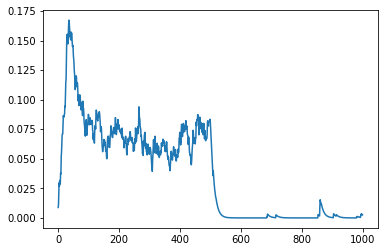

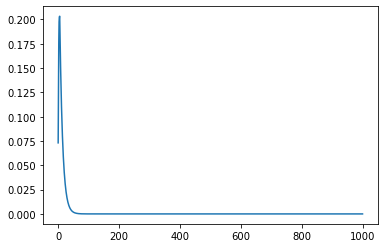

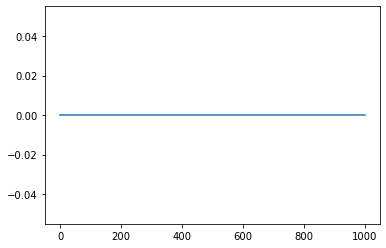

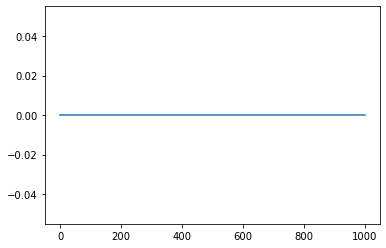

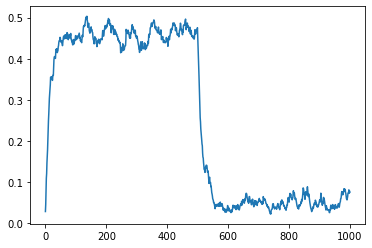

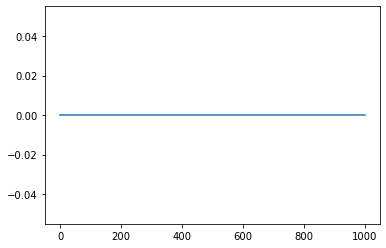

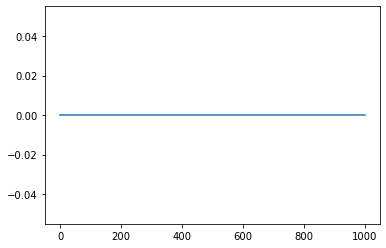

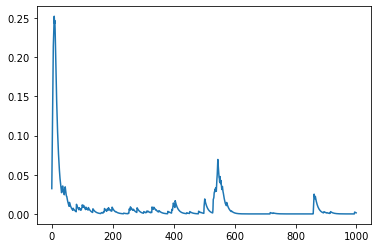

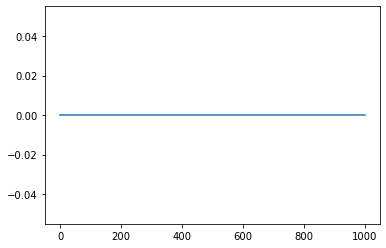

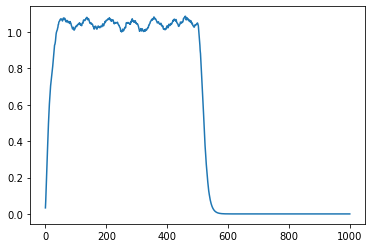

In [10]:
for i in range(10):
    fig, ax = plt.subplots()
    plt.plot(range(len(activations[:,i])), activations[:,i])
    plt.show()

In [11]:
net_weight_history = weight_history['trained weights']

In [12]:
print(len(net_weight_history))

100


## Drawing Network Evolution

Initial Weights

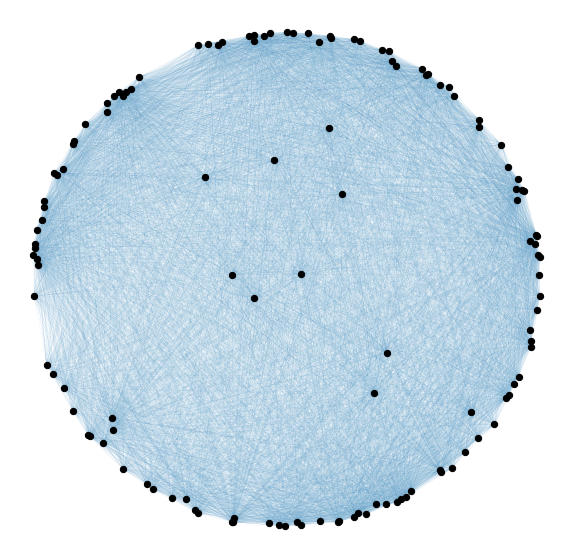

In [13]:
num_nodes = 128
G = nx.complete_graph(num_nodes)
for u,v,d in G.edges(data=True):
    d['weight'] = initial_weights[u,v] + initial_weights[v,u]
fig, ax = plt.subplots(figsize = [10,10])
options = {
    'node_color': 'black',
    'node_size': 40,
    'width': 0.05,
}
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
pos = nx.spring_layout(G,weight='weight', iterations=1000)
nx.draw(G,pos,edgelist=edges, edge_color=weights,edge_cmap=plt.cm.Blues, **options)
plt.show()

Mid-weights

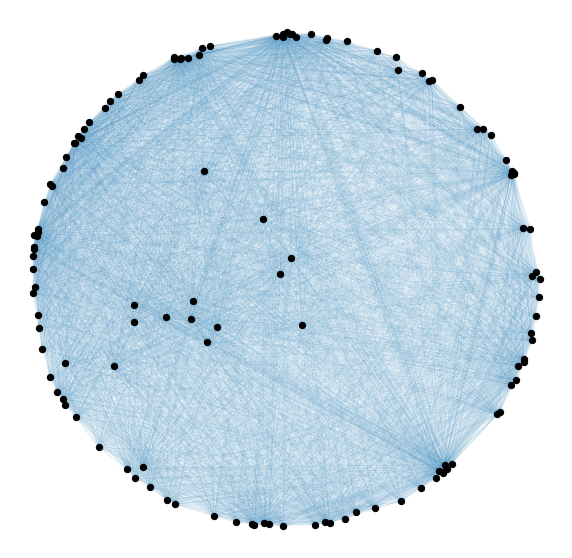

In [14]:
num_nodes = 128
G = nx.complete_graph(num_nodes)
weights=np.asarray(net_weight_history[len(net_weight_history)//2])
for u,v,d in G.edges(data=True):
    d['weight'] = weights[u,v] + weights[v,u]
fig, ax = plt.subplots(figsize = [10,10])
options = {
    'node_color': 'black',
    'node_size': 40,
    'width': 0.05,
}
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
pos = nx.spring_layout(G,weight='weight', iterations=1000)
nx.draw(G,pos,edgelist=edges, edge_color=weights,edge_cmap=plt.cm.Blues, **options)
plt.show()

Final Weights

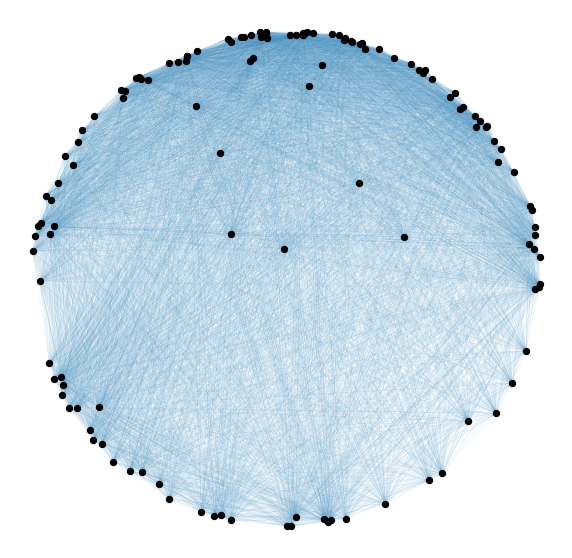

In [21]:
num_nodes = 128
G = nx.complete_graph(num_nodes)
for u,v,d in G.edges(data=True):
    d['weight'] = final_weights[u,v] + final_weights[v,u]
fig, ax = plt.subplots(figsize = [10,10])
options = {
    'node_color': 'black',
    'node_size': 40,
    'width': 0.05,
}
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
pos = nx.spring_layout(G,weight='weight', iterations=1000)
nx.draw(G,pos,edgelist=edges, edge_color=weights,edge_cmap=plt.cm.Blues, **options)
plt.show()

bottom is far more dense than top now, also few nodes have many strong weights. centerpieces are moving towards edges.

Final weight graph, nodes colored by whether activation is greater during first half of run

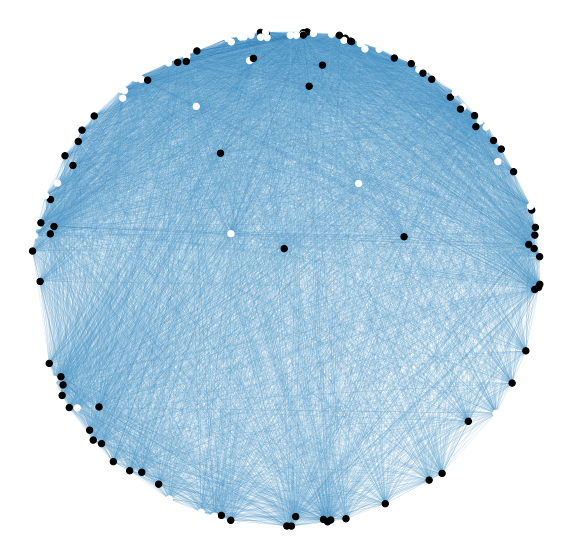

In [22]:
#color_lookup={k:np.mean(activations[:,k][0:500]) for k in np.asarray(G.nodes())}
colors=[]
for idx, node in enumerate(G.nodes()):
    if np.mean(activations[:,node][0:500]) > np.mean(activations[:, node][500:1000]):
        colors.append((1,1,1,1))
    else:
        colors.append((0,0,0,1))
#low, *_, high = sorted(color_lookup.values())
#print(low)
#print(high)
#norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=True)
#mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('gray'))

fig, ax = plt.subplots(figsize = [10,10])
options = {
    'node_color': colors,
    'node_size': 40,
    'width': 0.1,
}

nx.draw(G,pos,edgelist=edges, edge_color=weights,edge_cmap=plt.cm.Blues, **options)
plt.show()

Final weight graph, nodes colored by activation during second half of run

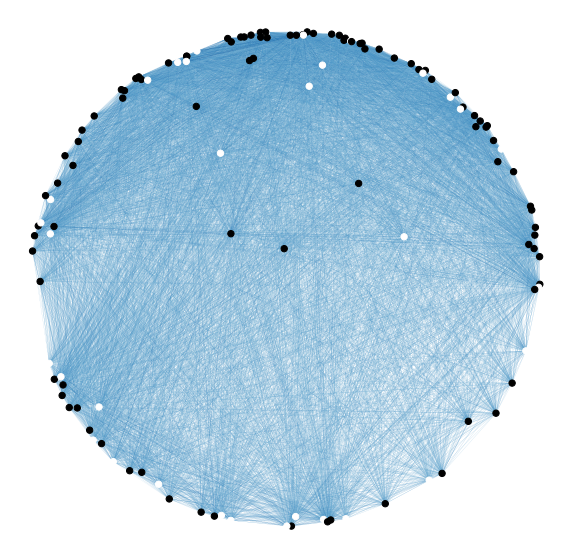

In [23]:
#color_lookup={k:np.mean(activations[:,k][500:1000]) for k in np.asarray(G.nodes())}
colors=[]
for idx, node in enumerate(G.nodes()):
    if np.mean(activations[:,node][500:1000]) > np.mean(activations[:, node][0:500]):
        colors.append((1,1,1,1))
    else:
        colors.append((0,0,0,1))
#low, *_, high = sorted(color_lookup.values())
#print(low)
#print(high)
#norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=True)
#mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('gray'))

fig, ax = plt.subplots(figsize = [10,10])
options = {
    'node_color': colors,
    'node_size': 40,
    'width': 0.1,
}

nx.draw(G,pos,edgelist=edges, edge_color=weights,edge_cmap=plt.cm.Blues, **options)
plt.show()

## Principal Values of Weight Matrix

Plotting change in singular values over training iteration

In [70]:
num_singular_values = 25
values = []
variance_prop = []
for mat in tqdm(net_weight_history):
    u, s, vh = np.linalg.svd(mat)
    values.append(s[:num_singular_values])
    tot_variance = np.dot(s,s)
    variance_prop.append([val**2/tot_variance for val in s])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 59.66it/s]


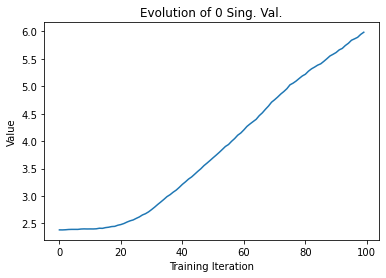

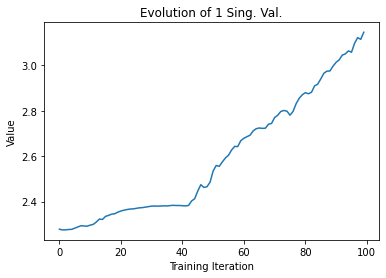

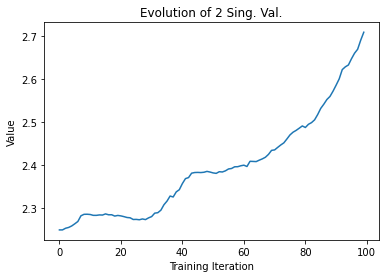

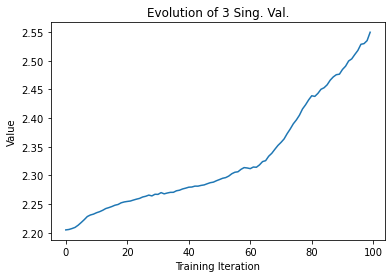

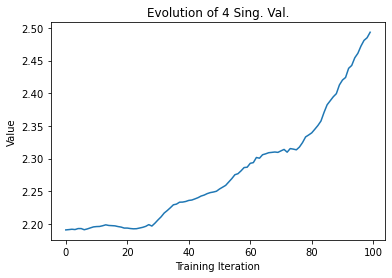

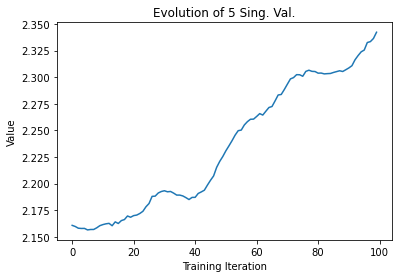

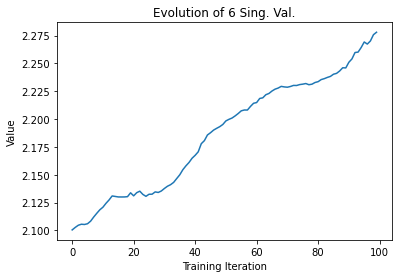

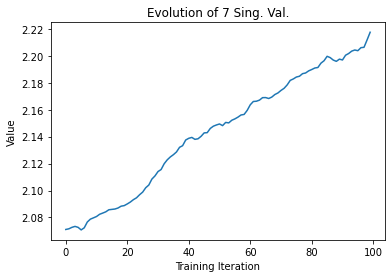

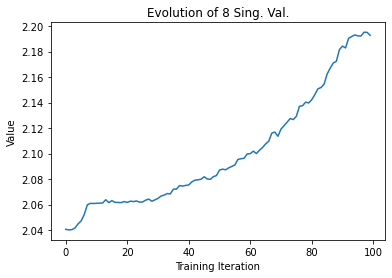

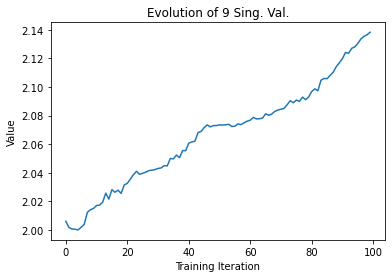

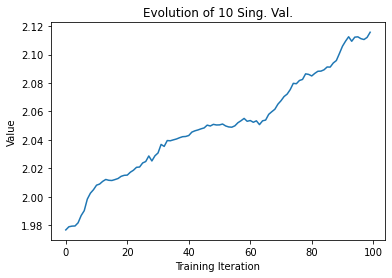

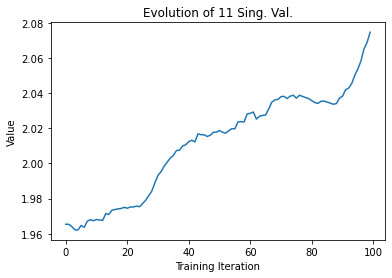

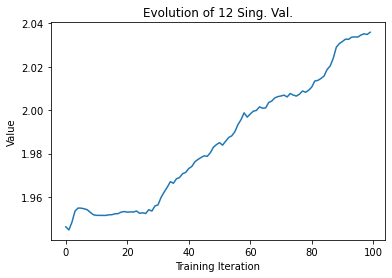

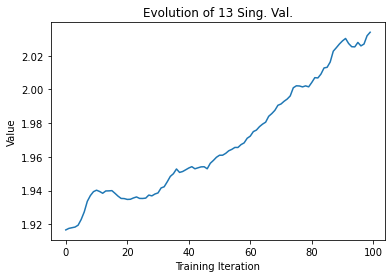

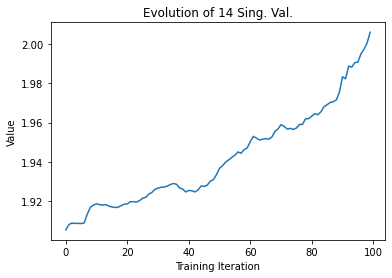

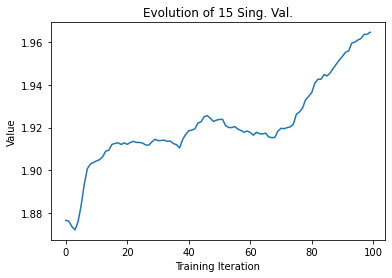

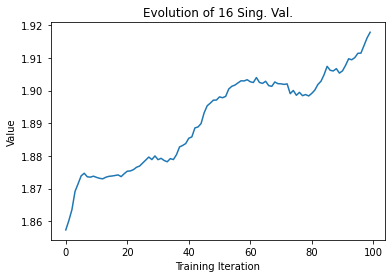

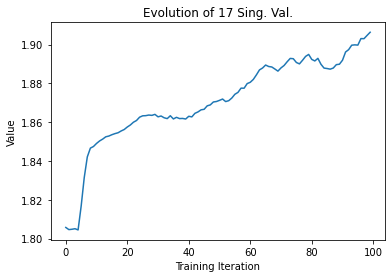

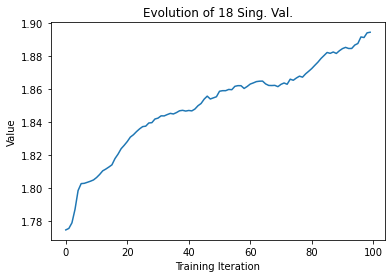

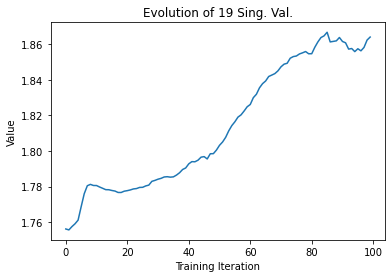

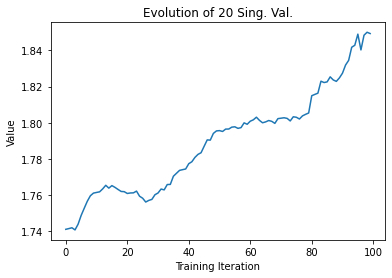

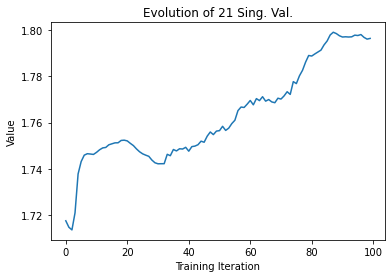

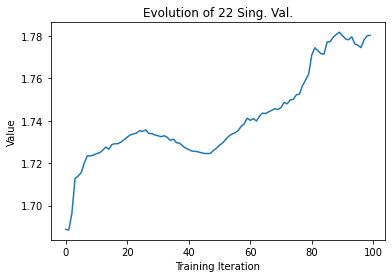

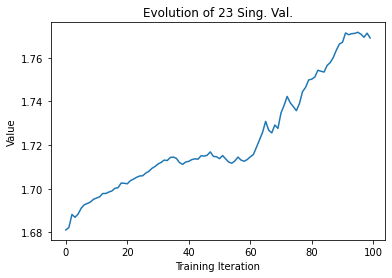

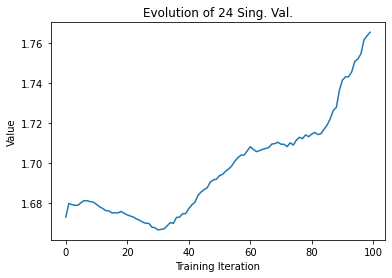

In [71]:
#The i'th column is the evolution of the i'th singular value
values = np.asarray(values)
num_total_iters = values[:, 0].shape[0]

for i in range(num_singular_values):
    fig, ax = plt.subplots()
    plt.plot(range(num_total_iters), values[:, i])
    plt.title('Evolution of ' + str(i) + ' Sing. Val.')
    plt.xlabel('Training Iteration')
    plt.ylabel('Value')
    plt.show()


Plotting percent variance captured in singular values over training iteration

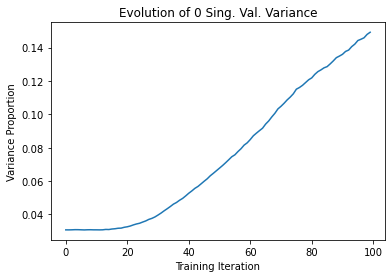

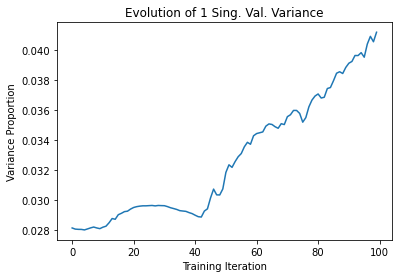

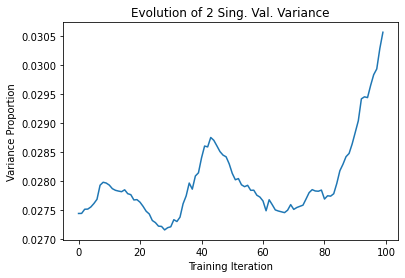

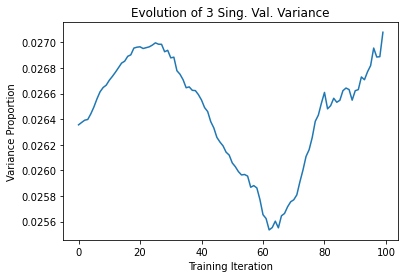

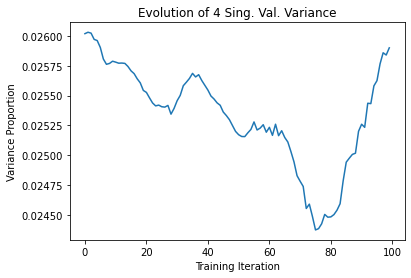

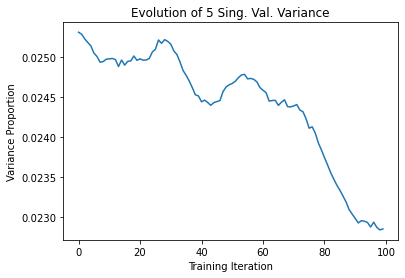

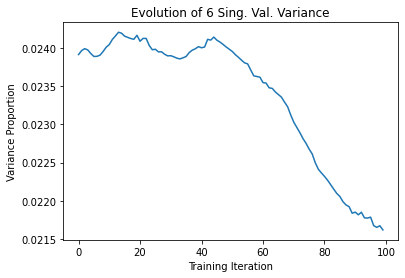

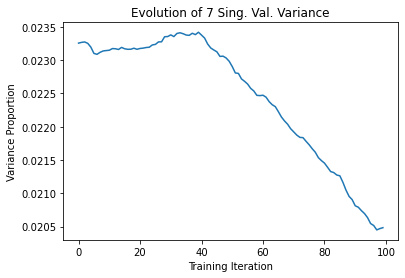

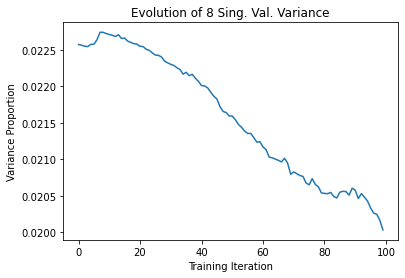

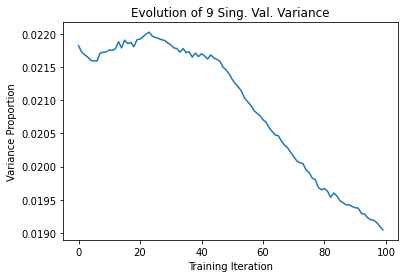

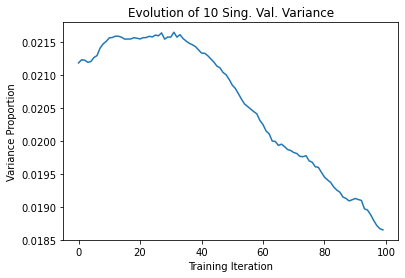

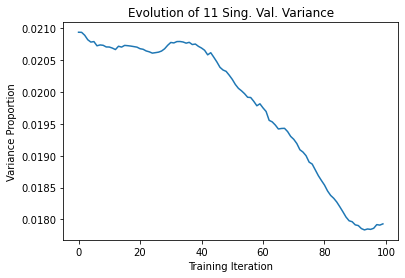

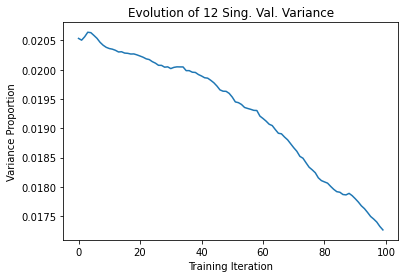

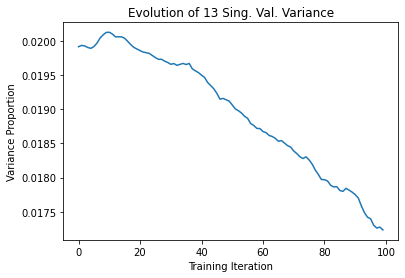

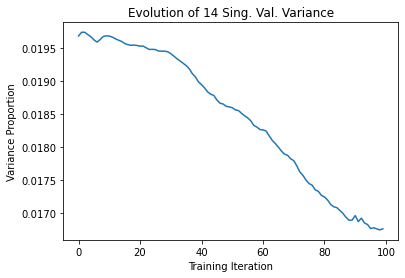

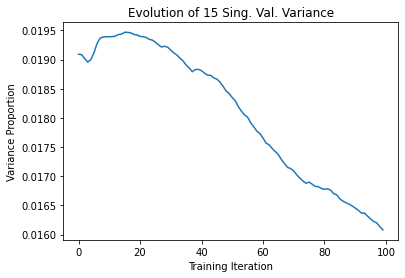

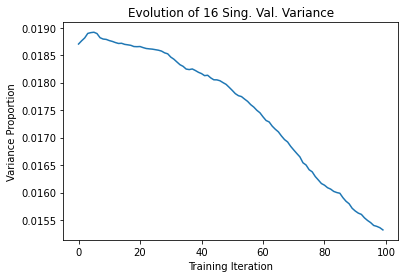

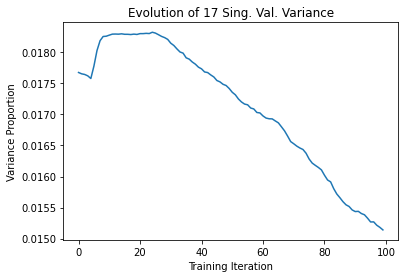

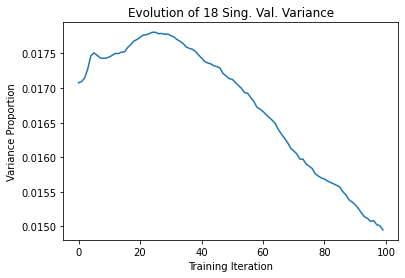

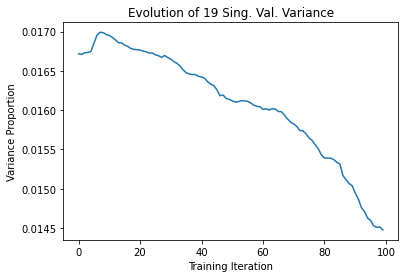

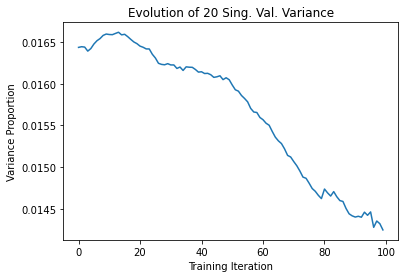

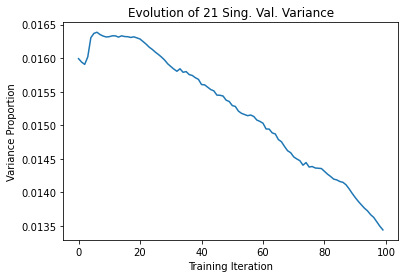

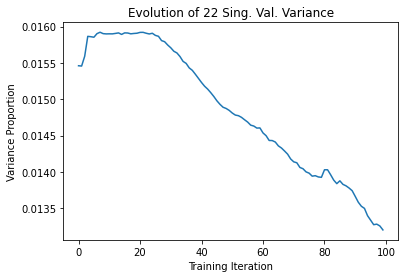

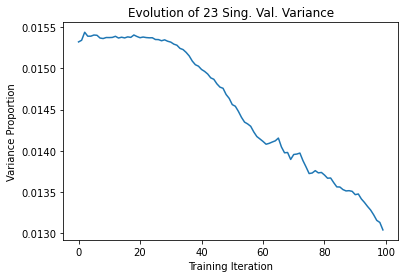

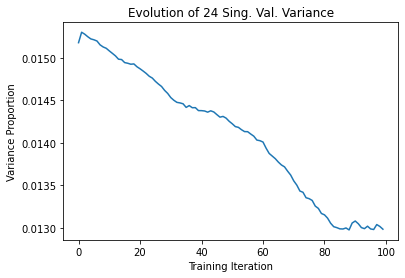

In [72]:
variance_prop = np.asarray(variance_prop)
for i in range(num_singular_values):
    fig, ax = plt.subplots()
    plt.plot(range(num_total_iters), variance_prop[:, i])
    plt.title('Evolution of ' + str(i) + ' Sing. Val. Variance')
    plt.xlabel('Training Iteration')
    plt.ylabel('Variance Proportion')
    plt.show()

## Schur Decomp.

Plotting sum of squares of off-diagonal components in schur decomposition of the matrices over training iteration

In [73]:
values = []
for mat in tqdm(net_weight_history):
    T, Z = slin.schur(mat)
    values.append(np.linalg.norm(T))
values = np.asarray(values)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 60.48it/s]


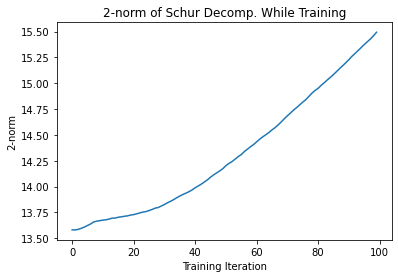

In [74]:
fig, ax = plt.subplots()
plt.plot(range(num_total_iters), values)
plt.xlabel('Training Iteration')
plt.ylabel('2-norm')
plt.title('2-norm of Schur Decomp. While Training')
plt.show()

## Looking at Weight Matrix

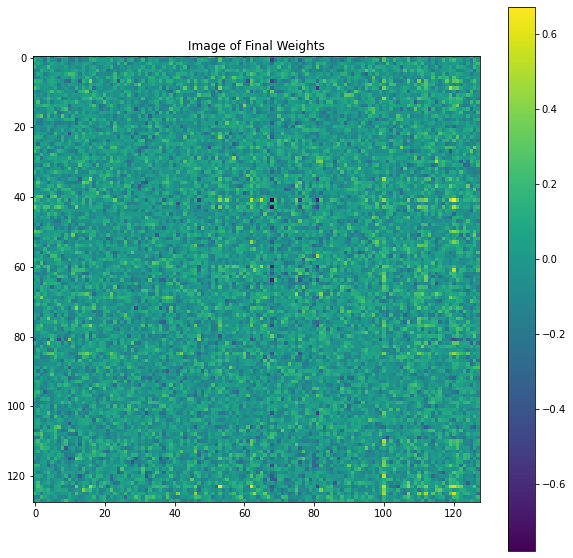

In [75]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.imshow(final_weights)
plt.title('Image of Final Weights')
plt.colorbar()

In [76]:
np.std(final_weights)

0.12103779005019552

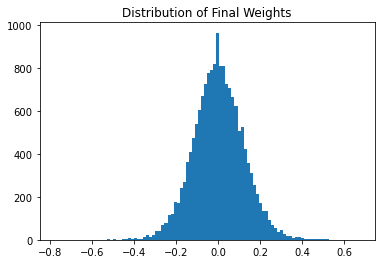

In [77]:
flattened = final_weights.flatten()
plt.hist(flattened, bins = 100)
plt.title('Distribution of Final Weights')
plt.show()

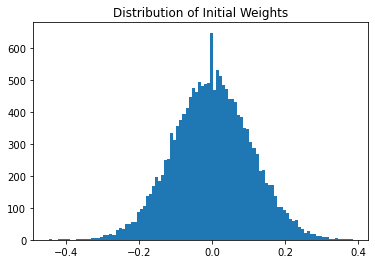

In [78]:
init = np.array(weight_history['trained weights'][0])
flattened = init.flatten()
plt.hist(flattened, bins = 100)
plt.title('Distribution of Initial Weights')
plt.show()

## Eigenvalues

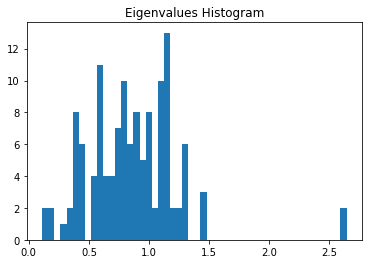

In [79]:
eig = np.linalg.eigvals(final_weights)
plt.hist(np.abs(eig), bins = 50)
plt.title('Eigenvalues Histogram')
plt.show()

## White Noise Input

In [80]:
#White noise input

time = 10000
network.reset_activations()
def rule_input(time):
    #running for 5 seconds = 5000ms
    return np.random.normal(0, 1)

input_funcs[2] = rule_input
inputs = network.convert(time, input_funcs)
outputs, activations = network.simulate(time, inputs, input_weight_matrix)


outputs = tf.transpose(outputs).numpy()[0]

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1228.77it/s]


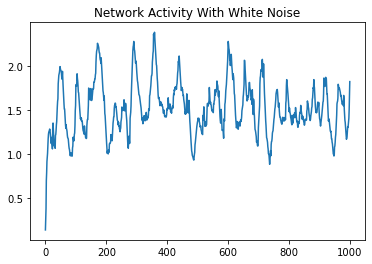

In [81]:
fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.title('Network Activity With White Noise')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'mat', 'time', 'eig', 'norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


Populating the interactive namespace from numpy and matplotlib


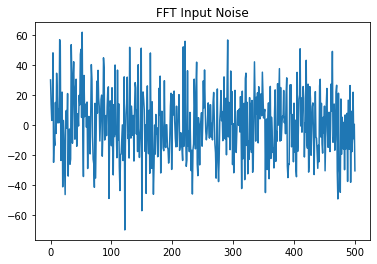

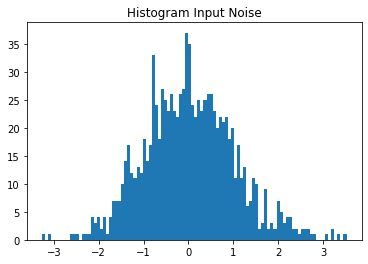

In [82]:
#Frequency space for Gaussian Noise
%pylab inline
fig1, ax1 = plt.subplots(1,1)
plt.plot(range(int(len(inputs[:, 2])/2) + 1), np.fft.rfft(inputs[:, 2]))
plt.title('FFT Input Noise')
fig1.show()

fig3, ax3 = plt.subplots(1,1)
plt.hist(np.asarray(inputs[:, 2]), bins = 100)
plt.title('Histogram Input Noise')
fig3.show()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


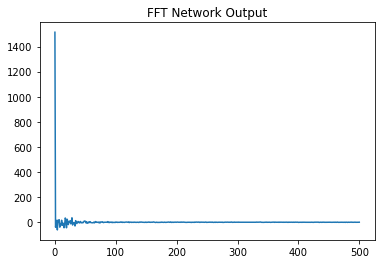

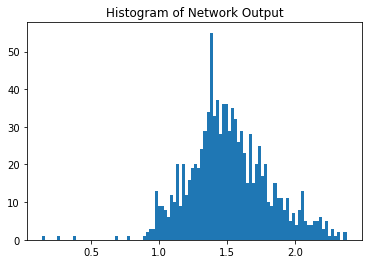

In [83]:
plt.plot(range(int(len(outputs)/2) + 1), np.fft.rfft(outputs))
plt.title('FFT Network Output')
plt.show()


plt.hist(outputs, bins = 100)
plt.title('Histogram of Network Output')
plt.show()

## Looking at Stationary Activity With Inputs Between 0, 1

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1116.57it/s]


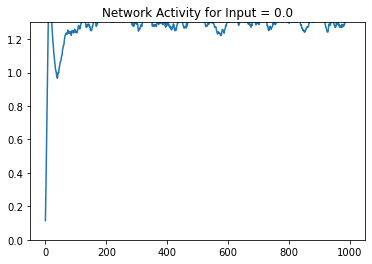

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1219.80it/s]


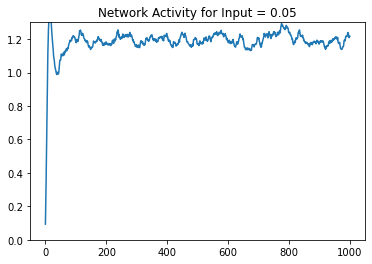

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1298.80it/s]


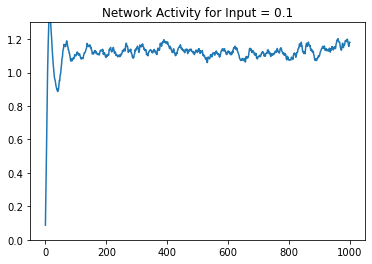

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 785.80it/s]


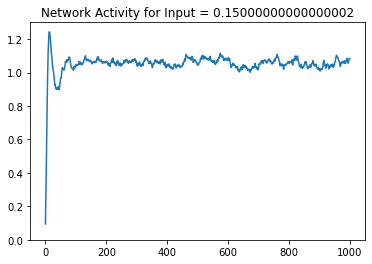

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 723.43it/s]


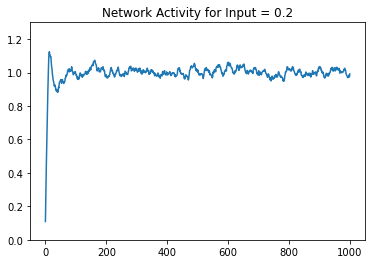

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 711.12it/s]


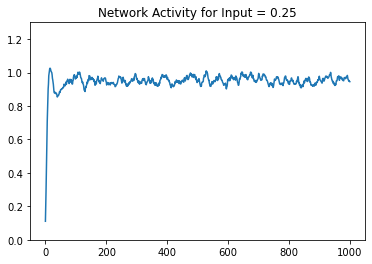

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1245.56it/s]


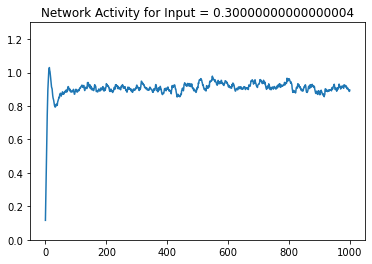

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1145.91it/s]


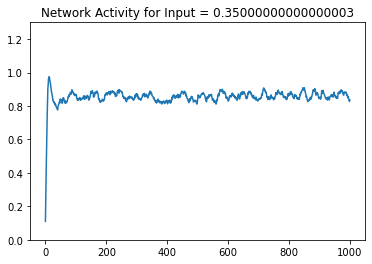

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1159.11it/s]


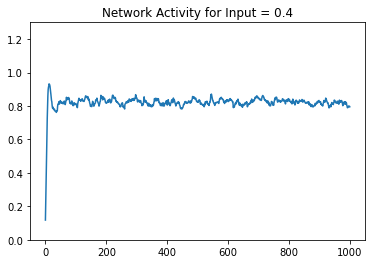

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1221.29it/s]


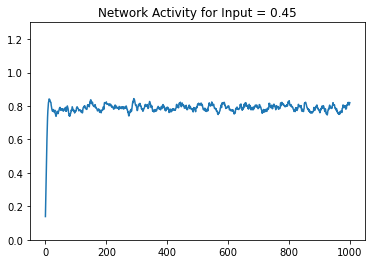

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1151.82it/s]


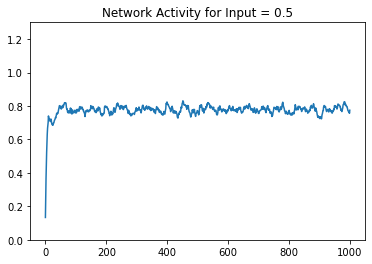

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1236.35it/s]


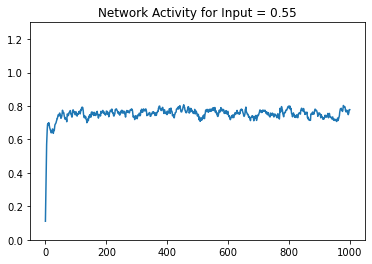

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1230.28it/s]


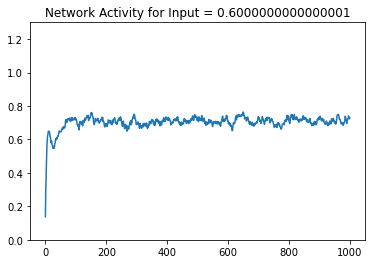

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1230.28it/s]


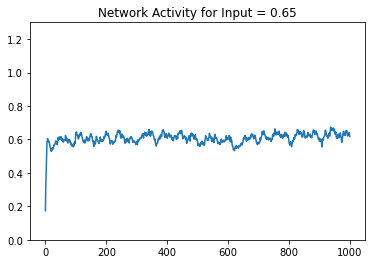

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1129.14it/s]


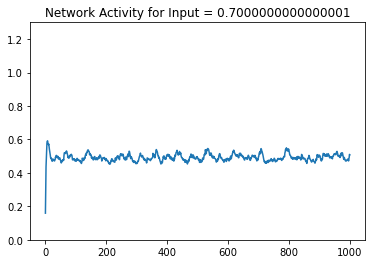

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 989.81it/s]


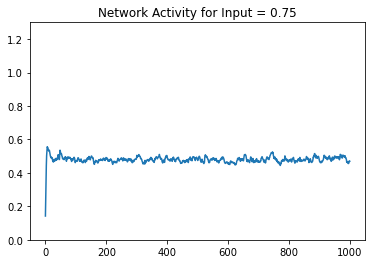

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1000.67it/s]


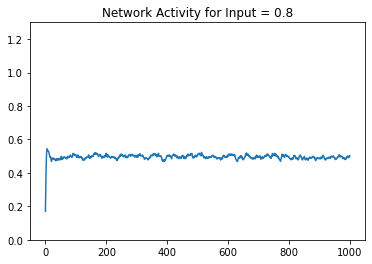

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1004.68it/s]


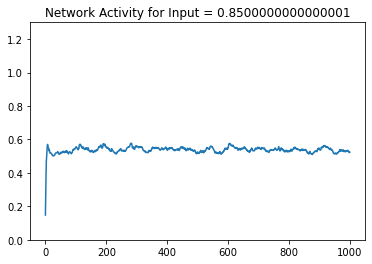

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 761.33it/s]


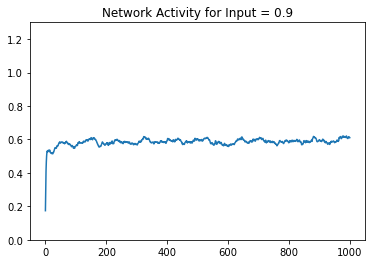

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 839.76it/s]


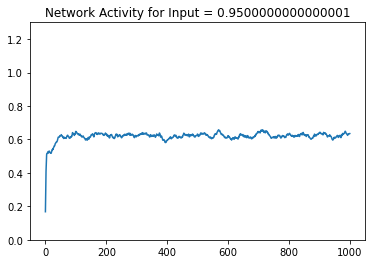

In [84]:
#Input is in range 0, 1
for n in range(20):
    time = 10000
    inp = n * 0.05
    network.reset_activations()
    def rule_input(time):
        #running for 5 seconds = 5000ms
        return inp + np.random.normal(0, 0.05)

    input_funcs[2] = rule_input
    inputs = network.convert(time, input_funcs)
    outputs, activations = network.simulate(time, inputs, input_weight_matrix)

    outputs = tf.transpose(outputs).numpy()[0]
    
    fig, ax = plt.subplots()
    plt.plot(range(len(outputs)), outputs)
    plt.title('Network Activity for Input = ' + str(inp))
    plt.ylim(0, 1.3)
    plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 691.02it/s]


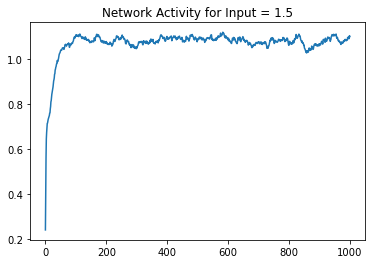

In [85]:
#Trying High input - Activity begins to increase again.
time = 10000
inp = 1.5
network.reset_activations()
def rule_input(time):
    #running for 5 seconds = 5000ms
    return inp + np.random.normal(0, 0.05)

input_funcs[2] = rule_input
inputs = network.convert(time, input_funcs)
outputs, activations = network.simulate(time, inputs, input_weight_matrix)

outputs = tf.transpose(outputs).numpy()[0]

fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.title('Network Activity for Input = ' + str(inp))
plt.show()

Plotting average activity value for different inputs

In [86]:
#Input is in range 0, 1
averages = []
inputs_arr = []
for n in tqdm(np.arange(-10, 40)):
    time = 10000
    inp = n * 0.05
    inputs_arr.append(inp)
    network.reset_activations()
    def rule_input(time):
        #running for 5 seconds = 5000ms
        return inp + np.random.normal(0, 0.05)

    input_funcs[2] = rule_input
    inputs = network.convert(time, input_funcs)
    outputs, activations = network.simulate(time, inputs, input_weight_matrix, disable_progress_bar = True)

    outputs = tf.transpose(outputs).numpy()[0]
    avg = np.mean(outputs)
    averages.append(avg)


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


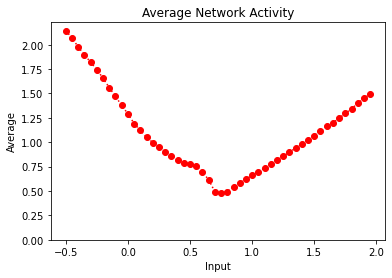

In [87]:
fig, ax = plt.subplots(1,1)
plt.plot(inputs_arr, averages, 'ro:')
plt.title('Average Network Activity')
plt.ylabel('Average')
plt.xlabel('Input')
plt.ylim(0)
plt.show()

## DCA Trajectories

This part requires installation of Dynamical Components Analysis from the BouchardLab GitHub

In [88]:
from dca.dca import DynamicalComponentsAnalysis as DCA
from sklearn.linear_model import Ridge as RR
from sklearn.metrics import r2_score
from scipy.linalg import subspace_angles
from sklearn.decomposition import PCA

1. Defining X matrix using dynamics of each node in the network (each row is a different timestep)
2. Then running DCA on this network activity to get a low-dimensional subspace.
3. Then fitting data to output using linear regression (no intercept) - plot r^2 score for fit.

In [89]:
time = 10000

#network.reset_activations()
def rule_input(time):
    #running for 15 seconds = 15000ms
    if time < 2500:
        return .5 + np.random.normal(0, .05)
    elif time >= 2500 and time < 7500:
        return .8 + np.random.normal(0, .05)
    else:
        return .5 + np.random.normal(0, .05)
def target_func(time):
    #Reverse of rule_input
    #running for 15 seconds = 15000ms
    if time < 2500:
        return .8
    elif time >= 2500 and time < 7500:
        return .5
    else:
        return .8

input_funcs[2] = rule_input
inputs = network.convert(time, input_funcs)

outputs, activations = network.simulate(time, inputs, input_weight_matrix)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 739.98it/s]


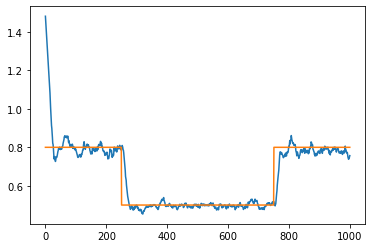

In [90]:
outputs = tf.transpose(outputs).numpy()[0]

fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.plot(range(len(outputs)), [target_func(t * timestep) for t in range(len(outputs))])
plt.show()

In [91]:
activations=[np.asarray(activation) for activation in activations]
activations = np.asarray(activations)

Running DCA on inputs

In [92]:
max_dim = 8
ds = np.arange(1, max_dim+1)

In [93]:
X = activations
Y = np.reshape(outputs, (outputs.size, 1))

In [94]:
pi = np.zeros(ds.size) #Predictive Information
dca_scores = np.zeros(ds.size)
dca_model = DCA(T=10, d=128)
dca_model.estimate_data_statistics(X) # only need to estimate this once
max_pi = dca_model.score() # PI of data with no dimensionality reduction

#rr_model = RR(alpha=1e-6)
#rr_model.fit(X, Y)
#max_score = r2_score(Y, rr_model.predict(X))

In [95]:
subspaces = []
for ii, d in enumerate(ds):
    print(d)
    dca_model.fit_projection(d=d)
    pi[ii] = dca_model.score()
    Xd = dca_model.transform(X)
    subspaces.append(Xd)
    #rr_model = RR(alpha=1e-6)
    #rr_model.fit(Xd, Y)
    #dca_scores[ii] = r2_score(Y, rr_model.predict(Xd))

1
2
3
4
5
6
7
8


Text(0, 0.5, '0-1 normalized metric')

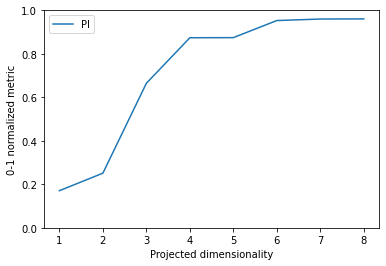

In [96]:
pi_curve_combined=np.asarray(pi)/max_pi.numpy()
plt.plot(ds, pi_curve_combined, label='PI')
#plt.plot(ds, dca_scores/max_score, label=r'$R^2$')
plt.ylim(0, 1)
plt.legend(loc='best')
plt.xlabel('Projected dimensionality')
plt.ylabel('0-1 normalized metric')

Plotting one-dimensional projection of neural activity

Text(0.5, 1.0, 'Plotting 1D Projection')

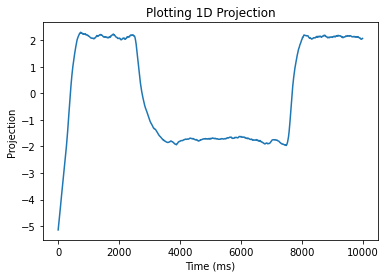

In [97]:
d = 1
dca_model.fit_projection(d=d)
pi[ii] = dca_model.score()
Xd = dca_model.transform(X)
plt.plot(np.arange(0, time, 10), Xd[:, 0])
plt.xlabel('Time (ms)')
plt.ylabel('Projection')
plt.title('Plotting 1D Projection')

Subspace angles for each projection (1D - 10D)

Plotting scatter of all subspace angles for each pair

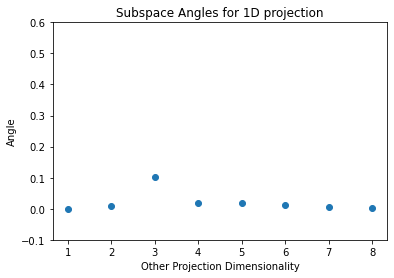

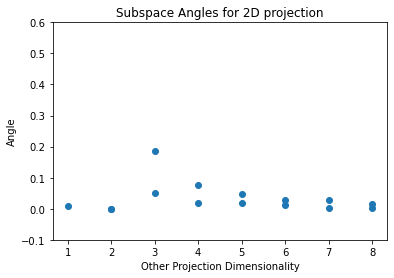

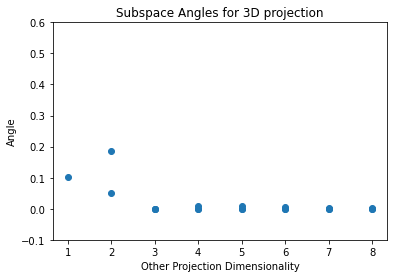

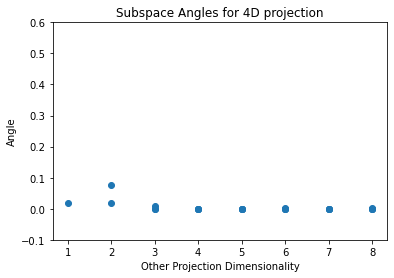

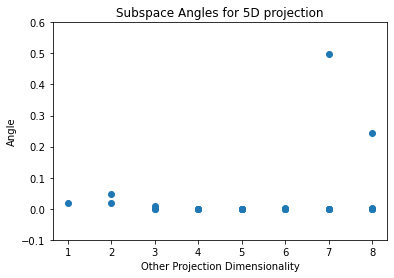

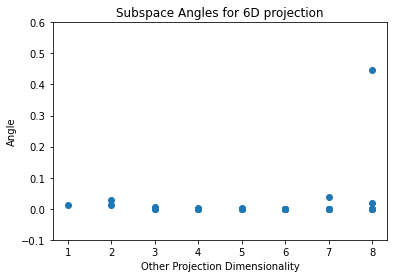

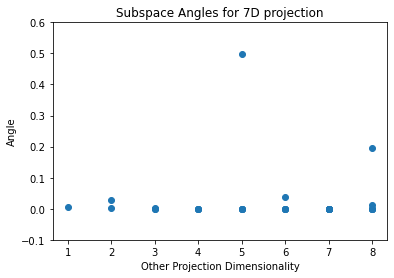

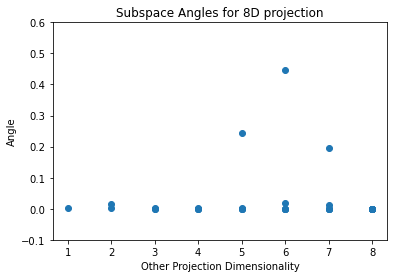

In [98]:
for d in ds:
    x = []
    y = []
    for tmpDim in ds:
        angls = subspace_angles(subspaces[d-1], subspaces[tmpDim - 1])
        x = np.append(x, tmpDim * np.ones(angls.size))
        y = np.append(y, angls)
    fig, ax = plt.subplots(1,1)
    ax.set_title('Subspace Angles for ' + str(d) + 'D projection')
    ax.set_xlabel('Other Projection Dimensionality')
    ax.set_ylabel('Angle')
    ax.scatter(x, y)
    plt.ylim(-0.1, 0.6)
    plt.show()

Subspace angles tend to be fairly low with a few outliers. For some reason, the 2D projection space has a lot of outliers?

Plot of DCA1 vs DCA2 for 2D projection

Accounts for 0.25129655384249755 of the predictive information


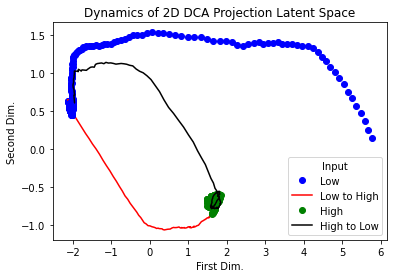

In [99]:
print('Accounts for ' + str((np.asarray(pi)/max_pi.numpy())[1]) + ' of the predictive information')
transition_times = [0, 250, 750, 1000]
change = 100

t = [transition_times[0],transition_times[1] - change , transition_times[1] + change
     , transition_times[2] - change, transition_times[2] + change, transition_times[3]]
plt.plot(subspaces[1][t[0]:t[1], 0], subspaces[1][t[0]:t[1], 1], 'bo', label = 'Low')
plt.plot(subspaces[1][t[1]:t[2], 0], subspaces[1][t[1]:t[2], 1], 'r-', label = 'Low to High')
plt.plot(subspaces[1][t[2]:t[3], 0], subspaces[1][t[2]:t[3], 1], 'go', label = 'High')
plt.plot(subspaces[1][t[3]:t[4], 0], subspaces[1][t[3]:t[4], 1], 'k-', label = 'High to Low')
plt.plot(subspaces[1][t[4]:t[5], 0], subspaces[1][t[4]:t[5], 1], 'bo')

plt.title('Dynamics of 2D DCA Projection Latent Space')
plt.xlabel('First Dim.')
plt.ylabel('Second Dim.')
plt.legend(title = 'Input')

Projecting dynamics onto 3D subspace

Text(0.5, 0, 'Third Dim.')

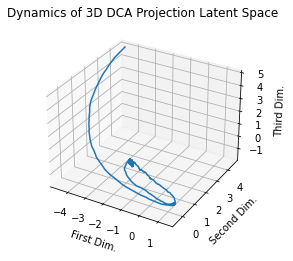

In [100]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(subspaces[2][:, 0], subspaces[2][:, 1], zs=subspaces[2][:, 2])
#ax.plot(subspaces[2][t[0]:t[1], 0], subspaces[2][t[0]:t[1], 1], zs=subspaces[2][t[0]:t[1], 2], 'bo', label = 'Low')
#ax.plot(subspaces[2][t[1]:t[2], 0], subspaces[2][t[1]:t[2], 1], zs=subspaces[2][t[1]:t[2], 2], 'r-', label = 'Low to High')
#ax.plot(subspaces[2][t[2]:t[3], 0], subspaces[2][t[2]:t[3], 1], zs=subspaces[2][t[2]:t[3], 2], 'go', label = 'High')
#ax.plot(subspaces[2][t[3]:t[4], 0], subspaces[2][t[3]:t[4], 1], zs=subspaces[2][t[3]:t[4], 2], 'k-', label = 'High to Low')
#ax.plot(subspaces[2][t[4]:t[5], 0], subspaces[2][t[4]:t[5], 1], zs=subspaces[2][t[4]:t[5], 2], 'bo')

plt.title('Dynamics of 3D DCA Projection Latent Space')
plt.xlabel('First Dim.')
plt.ylabel('Second Dim.')
ax.set_zlabel('Third Dim.')
#plt.legend(title = 'Input')

Plotting Network output using same time intervals and legend as above

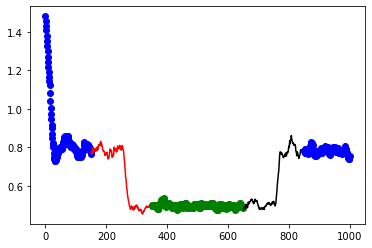

In [101]:
fig, ax = plt.subplots()
plt.plot(range(len(outputs))[t[0]:t[1]], outputs[t[0]:t[1]], 'bo')
plt.plot(range(len(outputs))[t[1]:t[2]], outputs[t[1]:t[2]], 'r-')
plt.plot(range(len(outputs))[t[2]:t[3]], outputs[t[2]:t[3]], 'go')
plt.plot(range(len(outputs))[t[3]:t[4]], outputs[t[3]:t[4]], 'k-')
plt.plot(range(len(outputs))[t[4]:t[5]], outputs[t[4]:t[5]], 'bo')
plt.show()

Observations: Trajectory transitions between two stationary states in latent space. The latent space projection shows the transition start prior to the network output changing. The latent space and output transition trajectory has little noise and the noise is only seen when the network is in its steady-state

Plot of PCA1 vs PCA2 for Dynamics

In [102]:
pca = PCA(n_components=2)
pca.fit(X)
print('The explained variance is:' + str(pca.explained_variance_ratio_))
X_pca = pca.transform(X)

The explained variance is:[0.852276   0.09292071]


Text(0, 0.5, 'Second Dim.')

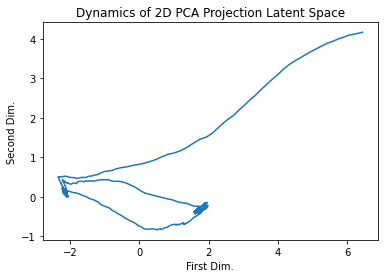

In [103]:
plt.plot(X_pca[:, 0], X_pca[:, 1])
plt.title('Dynamics of 2D PCA Projection Latent Space')
plt.xlabel('First Dim.')
plt.ylabel('Second Dim.')

### Running DCA on the different attractors and comparing

**input = .5**

In [104]:
time = 15000

network.reset_activations()
def rule_input(time):
    #running for 15 seconds = 15000ms
    return .5 + np.random.normal(0, .05)
def target_func(time):
    #Reverse of rule_input
    #running for 15 seconds = 15000ms
    return .8

input_funcs[2] = rule_input
inputs = network.convert(time, input_funcs)

outputs, activations = network.simulate(time, inputs, input_weight_matrix)

100%|█████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:02<00:00, 678.71it/s]


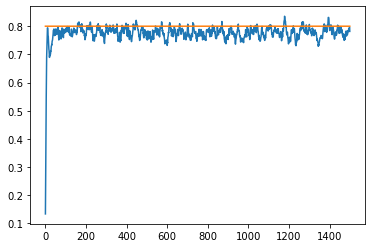

In [105]:
outputs = tf.transpose(outputs).numpy()[0]

fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.plot(range(len(outputs)), [target_func(t * timestep) for t in range(len(outputs))])
plt.show()

In [106]:
activations=[np.asarray(activation) for activation in activations]
activations = np.asarray(activations)

Running DCA on inputs

In [107]:
max_dim = 8
ds = np.arange(1, max_dim+1)

In [108]:
X = activations
Y = np.reshape(outputs, (outputs.size, 1))

In [109]:
pi = np.zeros(ds.size) #Predictive Information
dca_scores = np.zeros(ds.size)
dca_model = DCA(T=10, d=128)
dca_model.estimate_data_statistics(X) # only need to estimate this once
max_pi = dca_model.score() # PI of data with no dimensionality reduction

#rr_model = RR(alpha=1e-6)
#rr_model.fit(X, Y)
#max_score = r2_score(Y, rr_model.predict(X))

In [110]:
subspaces_low_inp = []
for ii, d in enumerate(ds):
    print(d)
    dca_model.fit_projection(d=d)
    pi[ii] = dca_model.score()
    Xd = dca_model.transform(X)
    subspaces_low_inp.append(Xd)
    #rr_model = RR(alpha=1e-6)
    #rr_model.fit(Xd, Y)
    #dca_scores[ii] = r2_score(Y, rr_model.predict(Xd))

1
2
3
4
5
6
7
8


Text(0, 0.5, '0-1 normalized metric')

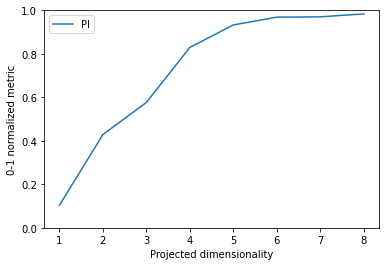

In [111]:
pi_curve_low=np.asarray(pi)/max_pi.numpy()
plt.plot(ds, pi_curve_low, label='PI')
#plt.plot(ds, dca_scores/max_score, label=r'$R^2$')
plt.ylim(0, 1)
plt.legend(loc='best')
plt.xlabel('Projected dimensionality')
plt.ylabel('0-1 normalized metric')

Plotting one-dimensional projection of neural activity

Text(0.5, 1.0, 'Plotting 1D projection')

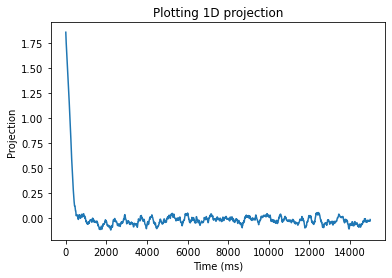

In [112]:
d = 1
dca_model.fit_projection(d=d)
pi[ii] = dca_model.score()
Xd = dca_model.transform(X)
plt.plot(np.arange(0, time, 10), Xd[:, 0])
plt.xlabel('Time (ms)')
plt.ylabel('Projection')
plt.title('Plotting 1D projection')

Plot of DCA1 vs DCA2 for 2D Projection

Text(0, 0.5, 'Second Dim.')

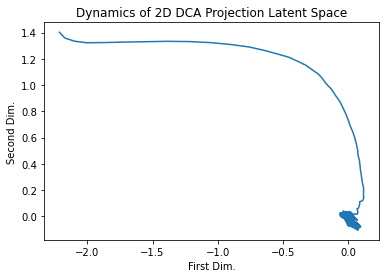

In [113]:
plt.plot(subspaces_low_inp[1][:, 0], subspaces_low_inp[1][:, 1])
plt.title('Dynamics of 2D DCA Projection Latent Space')
plt.xlabel('First Dim.')
plt.ylabel('Second Dim.')

Plot of PCA1 vs PCA2 for Dynamics

In [114]:
X_low_inp = X
pca = PCA(n_components=2)
pca.fit(X)
print('The explained variance is:' + str(pca.explained_variance_ratio_))
X_pca = pca.transform(X)

The explained variance is:[0.7539336  0.12030748]


Text(0, 0.5, 'Second Dim.')

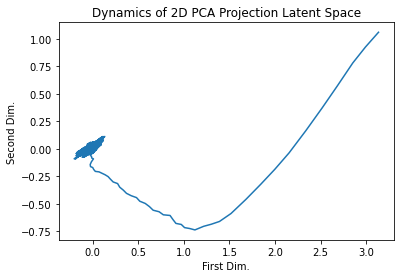

In [115]:
plt.plot(X_pca[:, 0], X_pca[:, 1])
plt.title('Dynamics of 2D PCA Projection Latent Space')
plt.xlabel('First Dim.')
plt.ylabel('Second Dim.')

**Input = .8**

In [116]:
time = 15000

network.reset_activations()
def rule_input(time):
    #running for 15 seconds = 15000ms
    return .8 + np.random.normal(0, .05)
def target_func(time):
    #Reverse of rule_input
    #running for 15 seconds = 15000ms
    return .5

input_funcs[2] = rule_input
inputs = network.convert(time, input_funcs)

outputs, activations = network.simulate(time, inputs, input_weight_matrix)

100%|█████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:02<00:00, 622.78it/s]


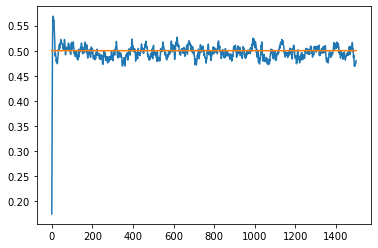

In [117]:
outputs = tf.transpose(outputs).numpy()[0]

fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.plot(range(len(outputs)), [target_func(t * timestep) for t in range(len(outputs))])
plt.show()

In [118]:
activations=[np.asarray(activation) for activation in activations]
activations = np.asarray(activations)

Running DCA on inputs

In [119]:
max_dim = 8
ds = np.arange(1, max_dim+1)

In [120]:
X = activations
Y = np.reshape(outputs, (outputs.size, 1))

In [121]:
pi = np.zeros(ds.size) #Predictive Information
dca_scores = np.zeros(ds.size)
dca_model = DCA(T=10, d=128)
dca_model.estimate_data_statistics(X) # only need to estimate this once
max_pi = dca_model.score() # PI of data with no dimensionality reduction

rr_model = RR(alpha=1e-6)
rr_model.fit(X, Y)
max_score = r2_score(Y, rr_model.predict(X))

In [122]:
subspaces_high_inp = []
for ii, d in enumerate(ds):
    print(d)
    dca_model.fit_projection(d=d)
    pi[ii] = dca_model.score()
    Xd = dca_model.transform(X)
    subspaces_high_inp.append(Xd)
    rr_model = RR(alpha=1e-6)
    rr_model.fit(Xd, Y)
    dca_scores[ii] = r2_score(Y, rr_model.predict(Xd))

1
2
3
4
5
6
7
8


Text(0, 0.5, '0-1 normalized metric')

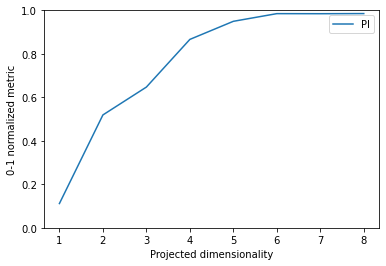

In [123]:
pi_curve_high=np.asarray(pi)/max_pi.numpy()
plt.plot(ds, pi_curve_high, label='PI')
#plt.plot(ds, dca_scores/max_score, label=r'$R^2$')
plt.ylim(0, 1)
plt.legend(loc='best')
plt.xlabel('Projected dimensionality')
plt.ylabel('0-1 normalized metric')

Plotting one-dimensional projection of neural activity

Text(0.5, 1.0, 'Fitting 1D projection to Output')

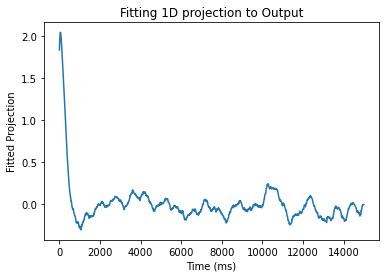

In [124]:
d = 1
dca_model.fit_projection(d=d)
pi[ii] = dca_model.score()
Xd = dca_model.transform(X)
plt.plot(np.arange(0, time, 10), Xd[:, 0])
plt.xlabel('Time (ms)')
plt.ylabel('Fitted Projection')
plt.title('Fitting 1D projection to Output')

Plot of DCA1 vs DCA2 of 2D Projection

Text(0, 0.5, 'Second Dim.')

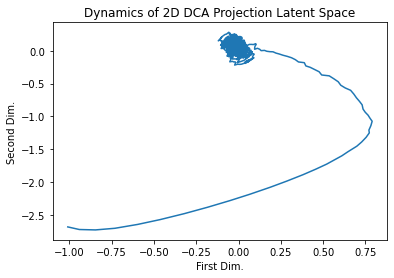

In [125]:
plt.plot(subspaces_high_inp[1][:, 0], subspaces_high_inp[1][:, 1])
plt.title('Dynamics of 2D DCA Projection Latent Space')
plt.xlabel('First Dim.')
plt.ylabel('Second Dim.')

Plot of PCA1 vs PCA2 for Dynamics

In [126]:
X_high_inp = X
pca = PCA(n_components=2)
pca.fit(X)
print('The explained variance is:' + str(pca.explained_variance_ratio_))
X_pca = pca.transform(X)

The explained variance is:[0.711277   0.13910067]


Text(0, 0.5, 'Second Dim.')

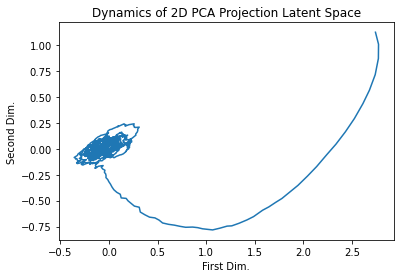

In [127]:
plt.plot(X_pca[:, 0], X_pca[:, 1])
plt.title('Dynamics of 2D PCA Projection Latent Space')
plt.xlabel('First Dim.')
plt.ylabel('Second Dim.')

**Plotting Subspace Angles Between Low Input and High Input**

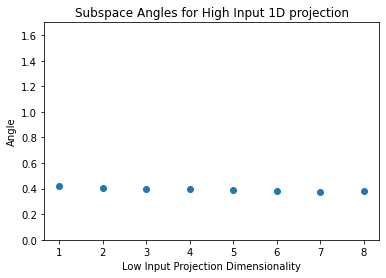

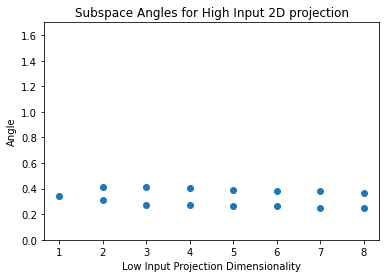

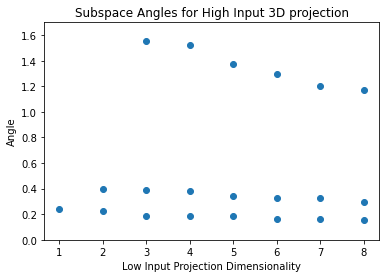

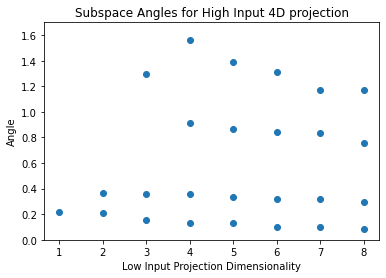

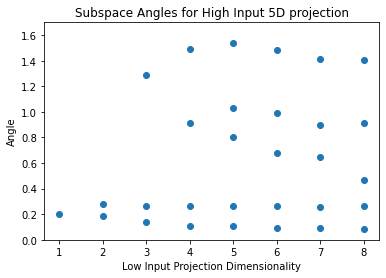

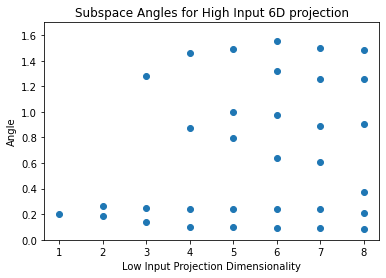

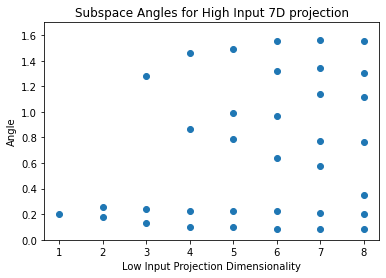

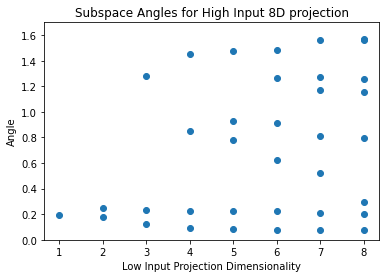

In [128]:
for d in ds:
    x = []
    y = []
    for tmpDim in ds:
        angls = subspace_angles(subspaces_high_inp[d-1], subspaces_low_inp[tmpDim - 1])
        x = np.append(x, tmpDim * np.ones(angls.size))
        y = np.append(y, angls)
    fig, ax = plt.subplots(1,1)
    ax.set_title('Subspace Angles for High Input ' + str(d) + 'D projection')
    ax.set_xlabel('Low Input Projection Dimensionality')
    ax.set_ylabel('Angle')
    ax.scatter(x, y)
    plt.ylim(0, 1.7)
    plt.show()

Plotting subspace angles for low and high input, same dimensionality

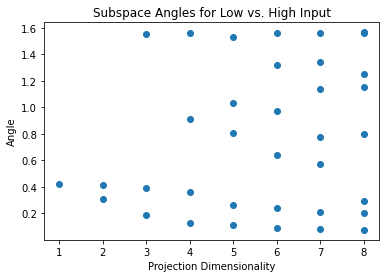

In [129]:
x = []
y = []
for d in ds:
    angls = subspace_angles(subspaces_high_inp[d-1], subspaces_low_inp[d - 1])
    x = np.append(x, d * np.ones(angls.size))
    y = np.append(y, angls)
fig, ax = plt.subplots(1,1)
ax.set_title('Subspace Angles for Low vs. High Input')
ax.set_xlabel('Projection Dimensionality')
ax.set_ylabel('Angle')
ax.scatter(x, y)
plt.show()

Orthogonal components begin to appear at 3D. The middle components begin to appear at 4-6D which is also where the PI curve begins to flatten out - nested subspaces appear first.

Plot of 1D projections from each attractor against each other

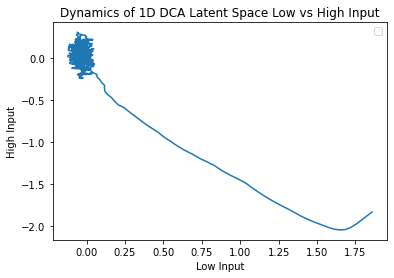

In [130]:
plt.plot(subspaces_low_inp[0][:, 0], subspaces_high_inp[0][:, 0])
plt.title('Dynamics of 1D DCA Latent Space Low vs High Input')
plt.xlabel('Low Input')
plt.ylabel('High Input')
plt.legend()

Plot of first PCA component of each attractor

In [131]:
pca_low = PCA(n_components=1)
pca_low.fit(X_low_inp)
print('The explained variance is:' + str(pca_low.explained_variance_ratio_))
X_pca_low = pca.transform(X_low_inp)

pca_high = PCA(n_components=1)
pca_high.fit(X_high_inp)
print('The explained variance is:' + str(pca_high.explained_variance_ratio_))
X_pca_high = pca.transform(X_high_inp)

The explained variance is:[0.7539334]
The explained variance is:[0.711277]


Text(0, 0.5, 'High Input')

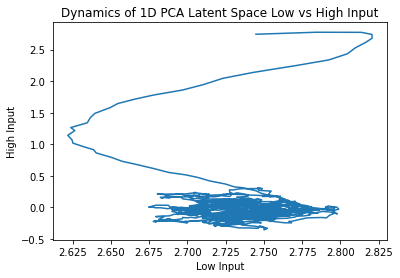

In [132]:
plt.plot(X_pca_low[:, 0], X_pca_high[:, 0])
plt.title('Dynamics of 1D PCA Latent Space Low vs High Input')
plt.xlabel('Low Input')
plt.ylabel('High Input')

PCA curves capture more noise. 

PI curve comparison

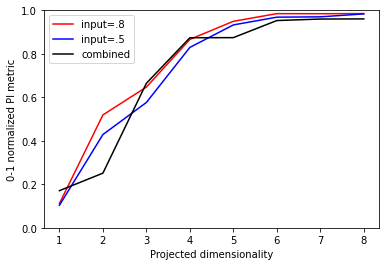

In [133]:
plt.plot(ds, pi_curve_high,'r-', label='input=.8')
plt.plot(ds, pi_curve_low,'b-', label='input=.5')
plt.plot(ds, pi_curve_combined,'k-', label='combined')
plt.ylim(0, 1)
plt.legend(loc='best')
plt.xlabel('Projected dimensionality')
plt.ylabel('0-1 normalized PI metric')
plt.legend()
plt.show()